In [1]:
import librosa
from librosa import display
import numpy as np
import matplotlib.pyplot as plt

In [2]:
wf, sr = librosa.load("vids/rollingstar/vocals.wav", sr=44100)

In [3]:
S_full, phase = librosa.magphase(librosa.stft(wf))

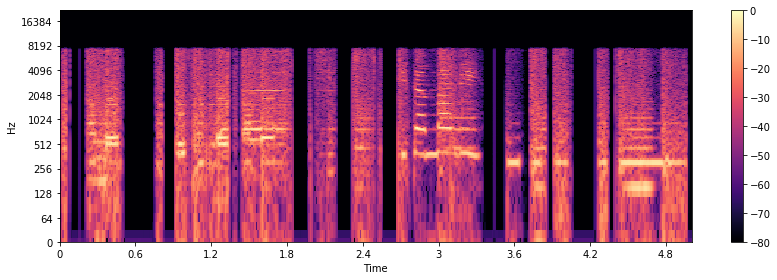

In [4]:
# Plot seconds 22-27.
idx = slice(*librosa.time_to_frames([22, 27], sr=sr))
plt.figure(figsize=(12, 4))
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.colorbar()
plt.tight_layout()

In [5]:
# We'll compare frames using cosine similarity, and aggregate similar frames
# by taking their (per-frequency) median value.
#
# To avoid being biased by local continuity, we constrain similar frames to be
# separated by at least 2 seconds.
#
# This suppresses sparse/non-repetetitive deviations from the average spectrum,
# and works well to discard vocal elements.

S_filter = librosa.decompose.nn_filter(S_full,
                                       aggregate=np.median,
                                       metric='cosine',
                                       width=int(librosa.time_to_frames(2, sr=sr)))

# The output of the filter shouldn't be greater than the input
# if we assume signals are additive.  Taking the pointwise minimium
# with the input spectrum forces this.
S_filter = np.minimum(S_full, S_filter)

In [6]:
# We can also use a margin to reduce bleed between the vocals and instrumentation masks.
# Note: the margins need not be equal for foreground and background separation
margin_i, margin_v = 2, 10
power = 2

mask_i = librosa.util.softmask(S_filter,
                               margin_i * (S_full - S_filter),
                               power=power)

mask_v = librosa.util.softmask(S_full - S_filter,
                               margin_v * S_filter,
                               power=power)

# Once we have the masks, simply multiply them with the input spectrum
# to separate the components

S_foreground = mask_v * S_full
S_background = mask_i * S_full

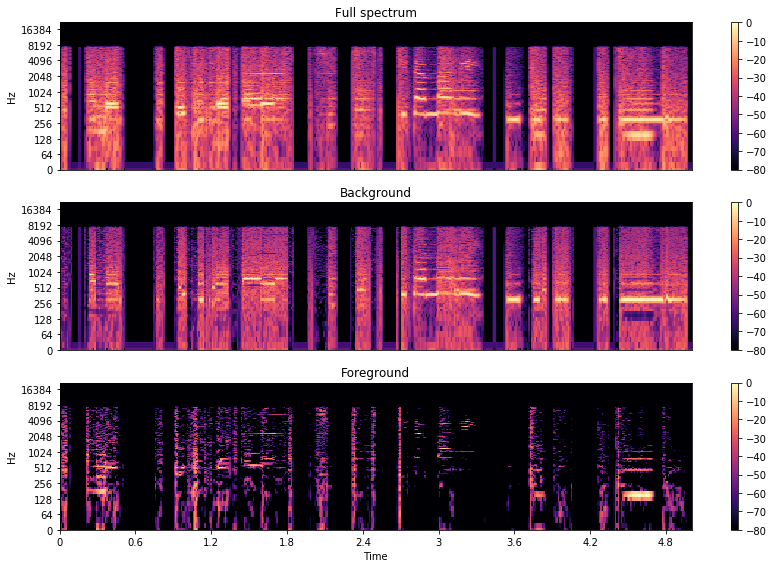

In [7]:
# sphinx_gallery_thumbnail_number = 2

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(S_full[:, idx], ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Full spectrum')
plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(S_background[:, idx], ref=np.max),
                         y_axis='log', sr=sr)
plt.title('Background')
plt.colorbar()
plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.amplitude_to_db(S_foreground[:, idx], ref=np.max),
                         y_axis='log', x_axis='time', sr=sr)
plt.title('Foreground')
plt.colorbar()
plt.tight_layout()
plt.show()

In [8]:
type(S_foreground)
print(np.shape(S_foreground))
print(S_foreground[456][200:230])

from scipy.io.wavfile import write
x = S_foreground.flatten()
y = np.int16(x/np.max(np.abs(x)) * 32767)
write("vids/rollingstar/vocals.wav", sr, y)

(1025, 29622)
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 4.1130626e-08 7.4188171e-07 5.5232711e-08 2.9472423e-08 5.0184821e-09
 3.1365698e-08 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 3.4058768e-08 1.6897739e-12 0.0000000e+00
 1.2088281e-08 4.8581018e-07 1.0169051e-06 9.6075127e-08 0.0000000e+00
 5.5842446e-09 2.9767932e-07 2.5260716e-09 7.5188353e-09 0.0000000e+00]


In [10]:
np.shape(S_foreground)
maxv = np.finfo(np.float32).max
#librosa.output.write_wav("vids/rollingstar/vocals.wav", S_foreground * maxv, sr)
#np.max(S_foreground)

In [11]:
rate = 44100
audio = np.random.uniform(-1, 1, size = (rate * 10, 2))
np.shape(audio)

(441000, 2)

In [12]:
tempo, beat_frames = librosa.beat.beat_track(y=wf, sr=sr)
print('Estimated tempo: {:.2f} beats per minute'.format(tempo))

Estimated tempo: 84.72 beats per minute


In [13]:
beat_times = librosa.frames_to_time(beat_frames, sr=sr)
print('Saving output to beat_times.csv')
librosa.output.times_csv('vids/rollingstar/beat_times.csv', beat_times)

Saving output to beat_times.csv


In [14]:
beat_times

array([  0.67337868,   1.42802721,   2.2523356 ,   3.06503401,
         3.81968254,   4.66721088,   5.41024943,   5.94430839,
         6.48997732,   7.18657596,   7.8831746 ,   8.62621315,
         9.35764172,  10.1355102 ,  10.70439909,  11.41260771,
        11.9814966 ,  12.70131519,  13.60689342,  14.34993197,
        15.0000907 ,  15.83600907,  16.56743764,  17.2524263 ,
        17.94902494,  18.66884354,  19.38866213,  20.06204082,
        20.65414966,  21.30430839,  22.02412698,  22.76716553,
        23.4521542 ,  24.32290249,  25.00789116,  25.72770975,
        26.41269841,  27.16734694,  27.82911565,  28.54893424,
        29.10621315,  29.96535147,  30.66195011,  31.38176871,
        32.07836735,  32.80979592,  33.4831746 ,  34.2029932 ,
        34.89959184,  35.61941043,  36.31600907,  37.02421769,
        37.72081633,  38.4522449 ,  39.12562358,  39.84544218,
        40.42594104,  41.28507937,  41.95845805,  42.66666667,
        43.36326531,  44.09469388,  44.77968254,  45.51

In [15]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats

matplotlib.style.use('ggplot')

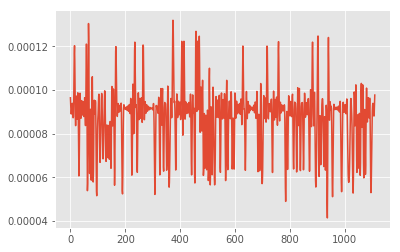

In [16]:
plt.plot(wf[8888:9999])

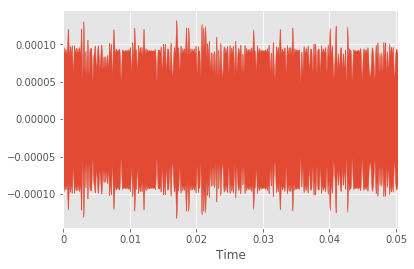

In [17]:
display.waveplot(wf[8888:9999])

In [18]:
harmonic, percussive = librosa.effects.hpss(wf)

In [19]:
htempo, hbeat_frames = librosa.beat.beat_track(y=harmonic, sr=sr)

In [20]:
hbeat_times = librosa.frames_to_time(hbeat_frames, sr=sr)

In [21]:
librosa.output.times_csv('vids/rollingstar/hbeat_times.csv', hbeat_times)